In [16]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# 2. Data preprocessing

In [17]:
df = pd.read_csv("data/high_diamond_ranked_10min.csv")
df.shape

(9879, 40)

In [18]:
# Checking missing value (NULL data)
df.isnull().sum()

gameId                          0
blueWins                        0
blueWardsPlaced                 0
blueWardsDestroyed              0
blueFirstBlood                  0
blueKills                       0
blueDeaths                      0
blueAssists                     0
blueEliteMonsters               0
blueDragons                     0
blueHeralds                     0
blueTowersDestroyed             0
blueTotalGold                   0
blueAvgLevel                    0
blueTotalExperience             0
blueTotalMinionsKilled          0
blueTotalJungleMinionsKilled    0
blueGoldDiff                    0
blueExperienceDiff              0
blueCSPerMin                    0
blueGoldPerMin                  0
redWardsPlaced                  0
redWardsDestroyed               0
redFirstBlood                   0
redKills                        0
redDeaths                       0
redAssists                      0
redEliteMonsters                0
redDragons                      0
redHeralds    

Out of the total 40 columns in the dataset, 20 of them are corresponding to the blue team, the other half belong to red team. 

This work will focus on analyzing and making prediction models on the blue team only, [as the outcomes for both teams are expected to be similar. ](#wr)

Therefore, the 20 latter columns comprising the red team's metrics are deemed redundant and insignificant for the purpose of the analysis.

In [19]:
# Drop repeatedly and redundant columns (e.g. gameId, red-based); retain the blue's metrics only.
df.drop(df.columns[[0] + list(range(21, 40))], inplace=True, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   blueWins                      9879 non-null   int64  
 1   blueWardsPlaced               9879 non-null   int64  
 2   blueWardsDestroyed            9879 non-null   int64  
 3   blueFirstBlood                9879 non-null   int64  
 4   blueKills                     9879 non-null   int64  
 5   blueDeaths                    9879 non-null   int64  
 6   blueAssists                   9879 non-null   int64  
 7   blueEliteMonsters             9879 non-null   int64  
 8   blueDragons                   9879 non-null   int64  
 9   blueHeralds                   9879 non-null   int64  
 10  blueTowersDestroyed           9879 non-null   int64  
 11  blueTotalGold                 9879 non-null   int64  
 12  blueAvgLevel                  9879 non-null   float64
 13  blu

In [20]:
# Custom color for plotting purpose
colors = {
    'red': '#ff9999',
    'blue' : '#66b3ff',
    'orange': '#ffcc99',
    'green' : '#99ff99'
}

<a id="wr"></a>

The following figure provides an explanation how analyzing blue team's metrics would be enough to represent both teams. Given that the probability of winning doesn't depend on the starting side.

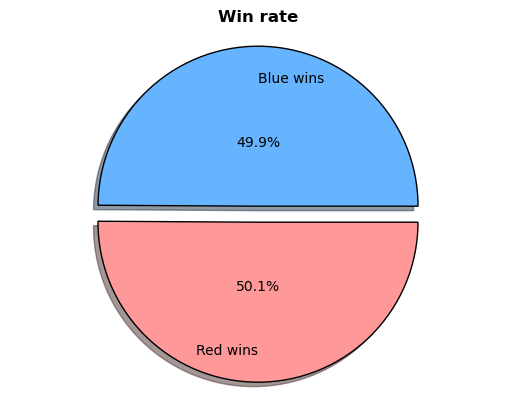

In [21]:
labels = ['Blue wins', 'Red wins']
sizes = [df.blueWins[df['blueWins'] == 1].count(), df.blueWins[df['blueWins'] == 0].count()]
explode = [0.1, 0]

plt.pie(sizes, labels=labels, colors=[colors['blue'], colors['red']], 
        autopct='%1.1f%%', pctdistance=0.4,
        explode=explode, shadow=True, wedgeprops={'edgecolor': 'black'},
       labeldistance=0.8,)

plt.title("Win rate", fontweight='bold')
plt.axis('equal')
plt.show()

## Data cleaning
### Handling collinearity

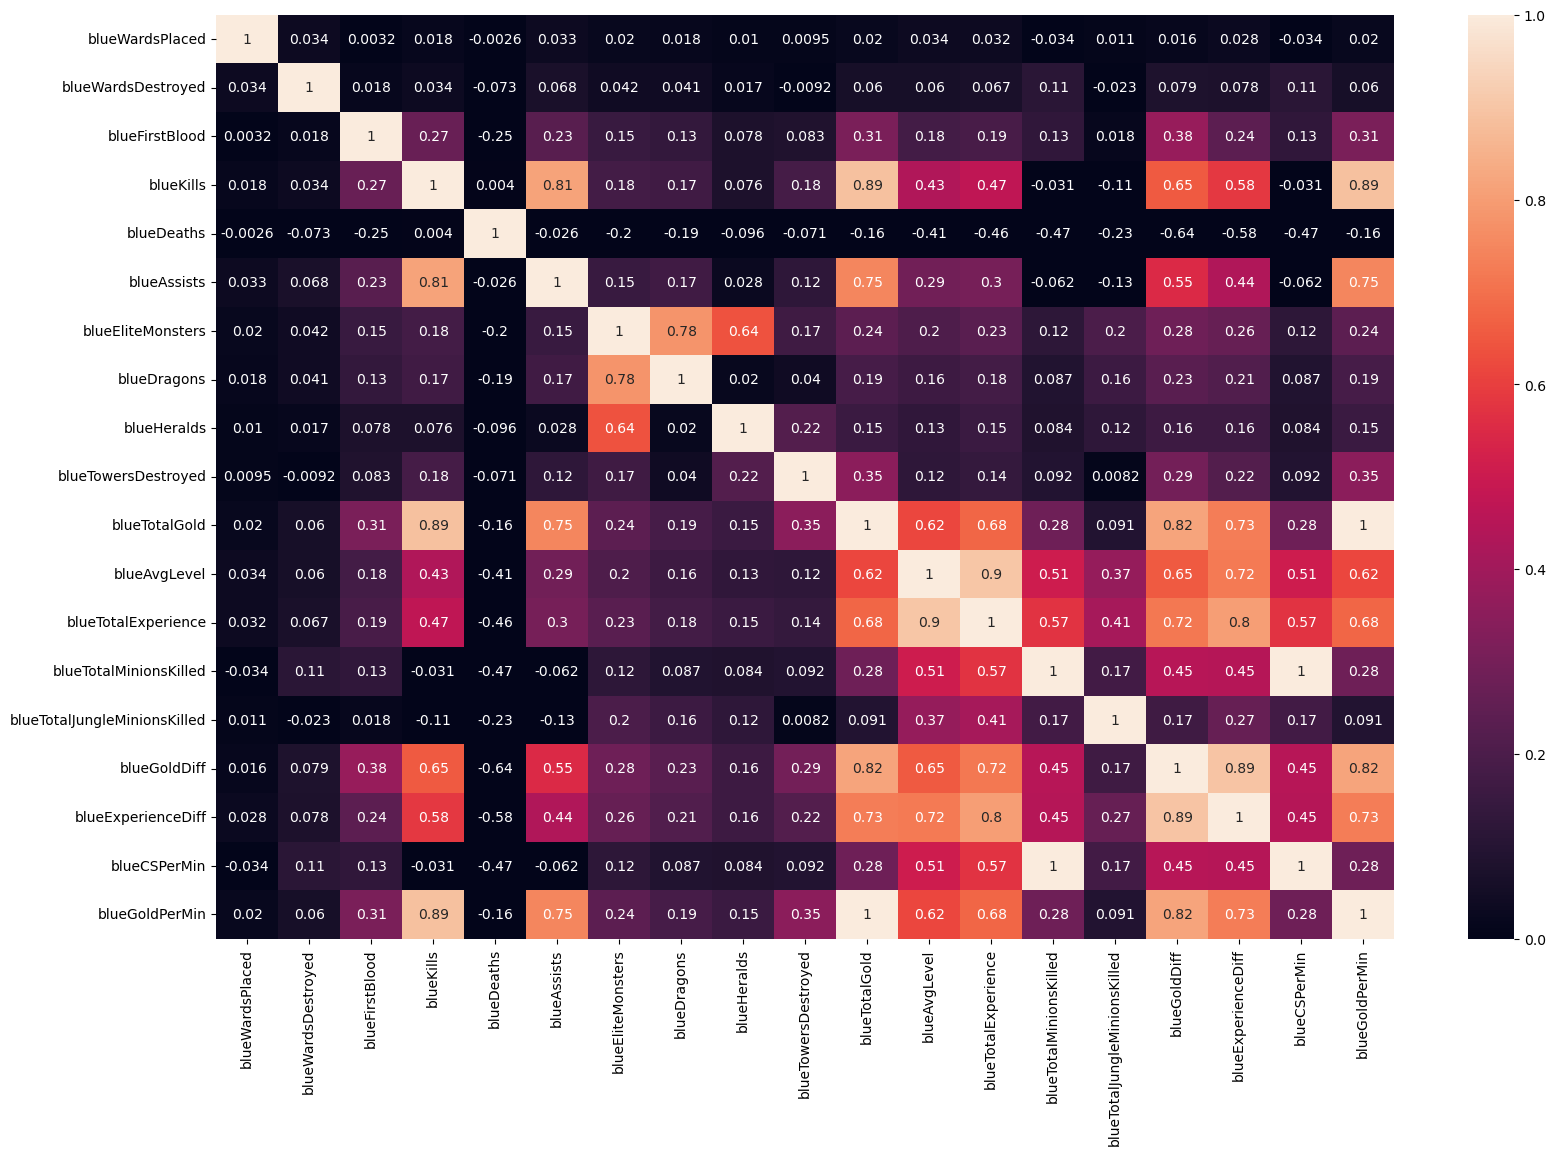

In [22]:
# Correlation matrix
# This work focuses on metrics with strong positively correlation,
# So we ignore the negative values by setting vmin=0

plt.figure(figsize=(19,12))
sns.heatmap(df.drop('blueWins', axis=1).corr(), annot=True, vmin=0)
plt.show()

In [23]:
# There is a multicollinearity between blueGoldPerMin and blueTotalGold,
# We drop one to avoid collinearity

df = df.drop('blueGoldPerMin', axis=1)

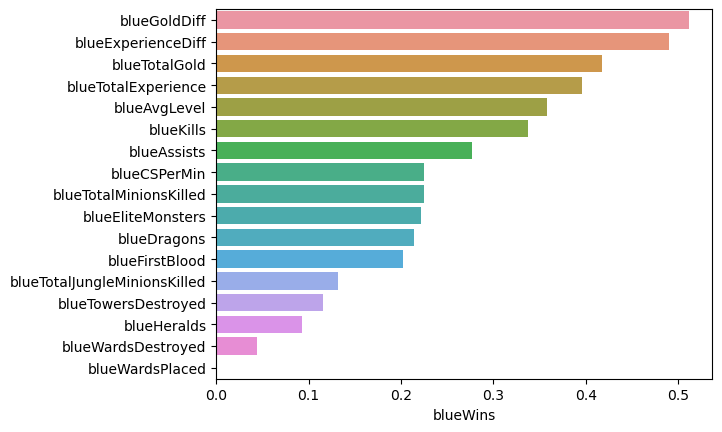

In [24]:
# Correlation of blue team's metrics with blueWins
# Dropping negative values (e.g. blueDeaths)

corr = df.corr()["blueWins"].drop(['blueWins', 'blueDeaths'])
corr = corr.sort_values(ascending=False)
sns.barplot(x=corr, y=corr.index)
plt.show()

Based on the information provided from the above correlation bar plot, it can be observed that **Gold and Experience** are most likely to impact win rate. While several others features such as **Kills, Assists, Minions count and Elite monsters** are also important. 

### Handling outliers

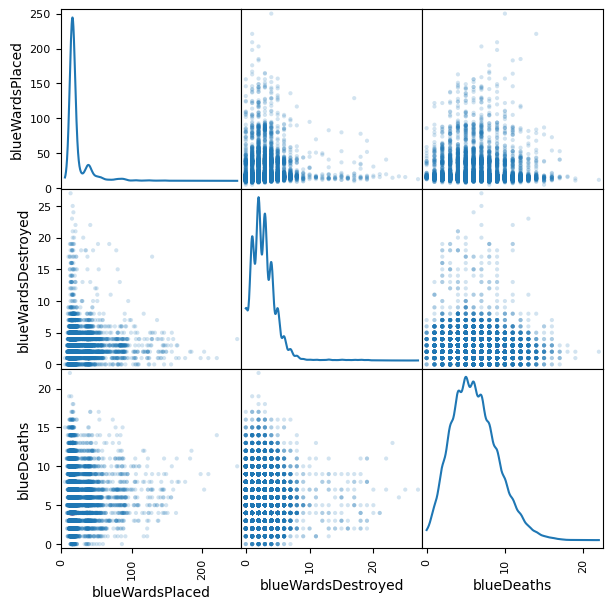

In [25]:
# We can spot several variables with significant low correlations
# We examine their outliers for more information

columns = ['blueWardsPlaced', 'blueWardsDestroyed', 'blueDeaths']
scatter_matrix(df[columns], alpha=.2, figsize=(7,7), diagonal='kde')
plt.show()

In [26]:
# Count occurence of outliers from the above scatter matrix

print(f"More than 130 wards placed: {len(df[df['blueWardsPlaced'] >= 130])} games")
print(f"More than 18 wards destroyed: {len(df[df['blueWardsDestroyed'] >= 18])} games")
print(f"More than 16 deaths: {len(df[df['blueDeaths'] >= 16])} games")

More than 130 wards placed: 48 games
More than 18 wards destroyed: 31 games
More than 16 deaths: 33 games


It is evident that the number of 30-50 occurences among 9879 records are remarkably small, hence those can be **considered as outliers**.

To decide whether should we drop those records, we take a closer look and examine base on game understandings.
- For 5 players to place more than 130 wards in the first 10 minutes of the game, each player has to place an average of 2-3 wards per minute. This is impossible for a normal game due to the cooldown time of a ward is 90 seconds. These scenarios happen when players abandoned the match and keep buying control wards. Hence these records are abnormally lose guaranteed and **should be excluded** for better analyzing.
- The records occuring more than 18 destroyed wards **should also be excluded** for the same reason, since the *oracle* cooldown is 120 seconds.
- For games having above 16 deaths, there could be a chance of having a player *inting*. The outcome of LOL matches bases on whole team's performance, so these games are not lose guaranteed. Therefore, **those records should be kept**.

*oracle*: A required item to destroy wards.

*inting*: Stands for "intentional feeding" and describes an action where a player loses on purpose to harm his/her own team.

In [27]:
# Retain the records satisfying disscussed conditions
df1 = df.loc[df['blueWardsPlaced'] < 130]
df1 = df1.loc[df1['blueWardsDestroyed'] < 18]

# Number of games removed
print(f'Removed {df.shape[0] - df1.shape[0]} outliers')

Removed 79 outliers


In [28]:
df1.head(5)

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin
0,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5
1,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4
2,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6
3,0,43,1,0,4,5,5,1,0,1,0,15157,7.0,17954,201,55,-1321,-7,20.1
4,0,75,4,0,6,6,6,0,0,0,0,16400,7.0,18543,210,57,-1004,230,21.0


To get better decisions, we examine plots of the variables that we considered significantly impact to the result of the game. There are two types of variable among them:
- Numerical variables: `blueGoldDiff`, `blueExperienceDiff`, `blueKills`, `blueTotalMinionsKilled`.
- Categorical variables for Elite monsters: `blueDragons`, `blueHeralds`. This is due to the fact that there is no second Herald or Dragon in the first 10 minutes of the game. The only 2 possible values are 0 and 1.


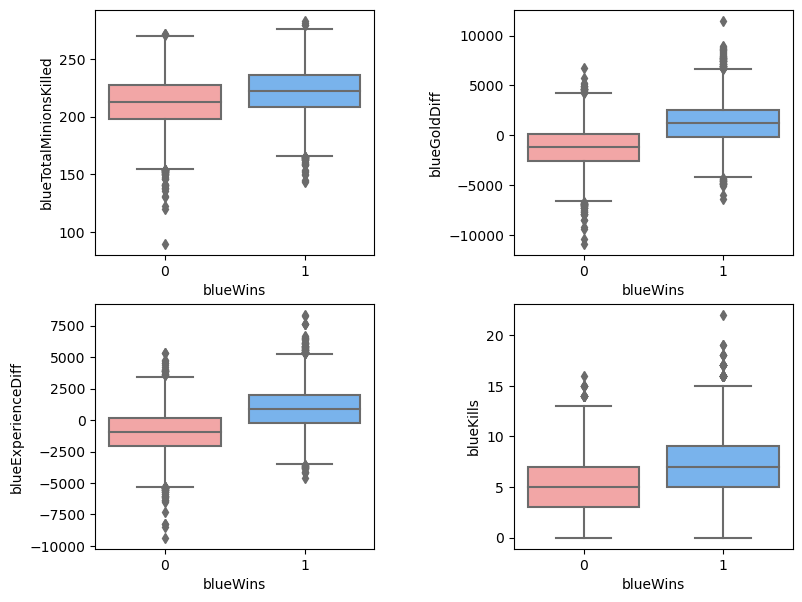

In [29]:
# For numerical variables

custom_palette = sns.color_palette(list(colors.values()))

fig, _ax = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
plt.subplots_adjust(wspace=0.5)

sns.boxplot(data=df1, x='blueWins', y='blueTotalMinionsKilled', palette=custom_palette, ax=_ax[0][0])
sns.boxplot(data=df1, x='blueWins', y='blueGoldDiff', palette=custom_palette, ax=_ax[0][1])
sns.boxplot(data=df1, x='blueWins', y='blueExperienceDiff', palette=custom_palette, ax=_ax[1][0])
sns.boxplot(data=df1, x='blueWins', y='blueKills', palette=custom_palette, ax=_ax[1][1])

plt.show()

Considering the patterns depicted in the 4 box plots, it is evident that **blue teams have a better average of gold, experience, kills and minions killed on its winning games**. This finding aligns with our initial assessment. 

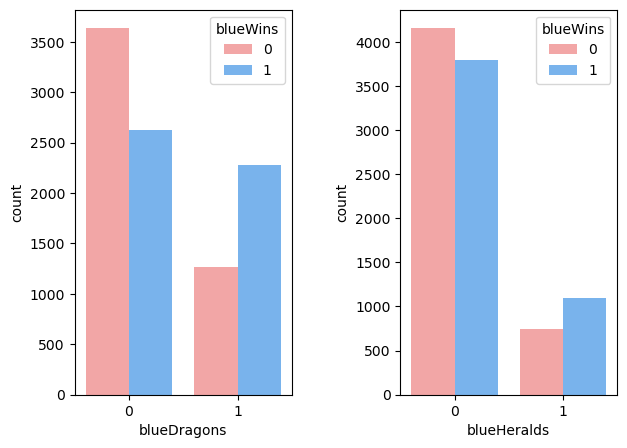

In [30]:
# Categorical variables
fig, _ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 5))
plt.subplots_adjust(wspace=0.5)
sns.countplot(data=df1, x='blueDragons', hue='blueWins', palette=custom_palette, ax=_ax[0])
sns.countplot(data=df1, x='blueHeralds', hue='blueWins', palette=custom_palette, ax=_ax[1])

plt.show()

It can be inferred that **blue team tend to win more in the games where they have the first Dragon or Herald**. This insight also supports our initial observation that Elite monsters are important and worth considering.

# 3. Feature engineering

## Feature creation

-`blueGoldDiff`, `blueExperienceDiff`, `blueKills`, `blueTotalMinionsKilled`.

-`blueDragons`, `blueHeralds`.

Now, we are confident to consider these features are important to the output of the game. To achive a more comprehensive data, we can drive an extra feature from `blueKills`:

`KDA`: a very important metric that provides insight into a player's effectiveness. In this case, team's effectiveness.

`KDA` = (Kills + Assists) / Deaths

Since number of deaths could be 0, we set this as 0.5 to guarantee error-free division.

In [31]:
df1['kda'] = np.where(df1['blueDeaths'] == 0, 
                      (df1['blueKills'] + df1['blueAssists']) / 0.5, 
                      (df1['blueKills'] + df1['blueAssists']) / df1['blueDeaths'])

In [33]:
from sklearn.model_selection import train_test_split

# Generate testing and training data
df_model = df1.copy()
x_features = df_model.loc[:, df_model.columns != 'blueWins']
y_target = df_model.blueWins
x_train, x_test, y_train, y_test = train_test_split(x_features, y_target, test_size=0.3, random_state=0, stratify=y_target)

In [34]:
# Determine categorical variables
x_train.nunique()

blueWardsPlaced                  113
blueWardsDestroyed                18
blueFirstBlood                     2
blueKills                         20
blueDeaths                        21
blueAssists                       29
blueEliteMonsters                  3
blueDragons                        2
blueHeralds                        2
blueTowersDestroyed                5
blueTotalGold                   3953
blueAvgLevel                      17
blueTotalExperience             3537
blueTotalMinionsKilled           145
blueTotalJungleMinionsKilled      72
blueGoldDiff                    4828
blueExperienceDiff              4373
blueCSPerMin                     145
kda                              313
dtype: int64

It is notable that the columns having lower than 3 unique values are categorical variables. We can utilize this property to extract them into `categorical_vars` and `numerical_vars`.

In [35]:
categorical_vars = [vars for vars in x_train if x_train[vars].nunique() < 4]
numerical_vars = [vars for vars in x_train if vars not in categorical_vars]

print(f"{pd.DataFrame(data=categorical_vars, columns=['Categorical variables'])}\n")
print(f"{pd.DataFrame(data=numerical_vars, columns=['Numerical variables'])}")

  Categorical variables
0        blueFirstBlood
1     blueEliteMonsters
2           blueDragons
3           blueHeralds

             Numerical variables
0                blueWardsPlaced
1             blueWardsDestroyed
2                      blueKills
3                     blueDeaths
4                    blueAssists
5            blueTowersDestroyed
6                  blueTotalGold
7                   blueAvgLevel
8            blueTotalExperience
9         blueTotalMinionsKilled
10  blueTotalJungleMinionsKilled
11                  blueGoldDiff
12            blueExperienceDiff
13                  blueCSPerMin
14                           kda


In [36]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical variables
scaler = StandardScaler()
scaler.fit(x_train[numerical_vars])
x_train[numerical_vars] = scaler.transform(x_train[numerical_vars])
x_test[numerical_vars] = scaler.transform(x_test[numerical_vars])

# 4. Model fitting and selection

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import cross_val_score, cross_val_predict

In [38]:
# Logistic Regression
LR = LogisticRegression()
LR_scores = cross_val_score(estimator=LR, X=x_train, y=y_train, cv=3)
LR_mean = LR_scores.mean()

# Support Vector Machine
_SVC = SVC()
SVC_scores = cross_val_score(estimator=_SVC, X=x_train, y=y_train, cv=3)
SVC_mean = SVC_scores.mean()

# K Nearest Neighbors Classifier
KNN = KNeighborsClassifier()
KNN_scores = cross_val_score(estimator=KNN, X=x_train, y=y_train, cv=3)
KNN_mean = KNN_scores.mean()

# Multi-layer Perceptron Classifier
MLPC = MLPClassifier(alpha=1)
MLPC_scores = cross_val_score(estimator=MLPC, X=x_train, y=y_train, cv=3)
MLPC_mean = MLPC_scores.mean()

# Gradient Boosting Classifier
GBC = GradientBoostingClassifier()
GBC_scores = cross_val_score(estimator=GBC, X=x_train, y=y_train, cv=3)
GBC_mean = GBC_scores.mean()

# Random Forest Classifier
RFC = RandomForestClassifier()
RFC_scores = cross_val_score(estimator=RFC, X=x_train, y=y_train, cv=3)
RFC_mean = RFC_scores.mean()

# Gaussian Naive Baiyes
NB = GaussianNB()
NB_scores = cross_val_score(estimator=NB, X=x_train, y=y_train, cv=3)
NB_mean = NB_scores.mean()

In [39]:
Classifier_name = {
    LR: 'Logistic Regression', 
    _SVC: 'Support Vector Machine', 
    KNN: 'K Nearest Neighbors Classifier', 
    MLPC: 'Multi-layer Perceptron Classifier', 
    GBC: 'Gradient Boosting Classifier',
    RFC: 'Random Forest Classifier', 
    NB: 'Gaussian Naive Baiyes'
}

# Store the results in a data frame
mean_dict = {
    'Classifier' : list(Classifier_name.values()),
    'CV Score' : [LR_mean, SVC_mean, KNN_mean, MLPC_mean, GBC_mean, RFC_mean, NB_mean]}

result = pd.DataFrame(data=mean_dict)
result = result.sort_values(by='CV Score', ascending=False)
result

,Classifier,CV Score
4,Gradient Boosting Classifier,0.733527
0,Logistic Regression,0.731779
1,Support Vector Machine,0.728863
3,Multi-layer Perceptron Classifier,0.728135
5,Random Forest Classifier,0.725511
6,Gaussian Naive Baiyes,0.719388
2,K Nearest Neighbors Classifier,0.685276


It is apparent that the four top performanced classifiers are: **Gradient Boosting Classifier, Logistic Regression, SVM and MLP Classifier**. Hence, we select these four as candidates for further evaluation on other metrics.

In [40]:
from sklearn.metrics import accuracy_score, f1_score

# Function to evaluate classifier on accuracy, precision, recall and f1 score.
def evaluate_classifier(_estimator, _y_predict):
    _estimator.fit(x_train, y_train)
    
    classifier = Classifier_name[_estimator]
    accuracy = accuracy_score(y_train, _y_predict)
    precision = precision_score(y_train, _y_predict)
    recall = recall_score(y_train, _y_predict)
    f1 = f1_score(y_train, _y_predict)
    
    return pd.Series([classifier, accuracy, precision, recall, f1], 
                     index = ['Classifier', 'Accuracy score', 'Precision score', 
                              'Recall score', 'F1 score'])

In [41]:
evaluations = []

# The four classifiers with highest CV score
candidate_classifier = [LR, MLPC, _SVC, GBC]

candidate_classifier
for classifier in candidate_classifier:
    y_predict = cross_val_predict(estimator=classifier, X=x_train, y=y_train, cv=3)
    classifier_evaluation = evaluate_classifier(classifier, y_predict)
    evaluations.append(classifier_evaluation)
    
evaluations = pd.DataFrame(evaluations, 
                           columns = ['Classifier', 'Accuracy score', 'Precision score', 
                                      'Recall score', 'F1 score'])

In [42]:
evaluations = evaluations.sort_values(by="Accuracy score", ascending=False)
evaluations

,Classifier,Accuracy score,Precision score,Recall score,F1 score
3,Gradient Boosting Classifier,0.733382,0.733353,0.732711,0.733032
0,Logistic Regression,0.731778,0.732630,0.729209,0.730915
2,Support Vector Machine,0.728863,0.728492,0.728917,0.728705
1,Multi-layer Perceptron Classifier,0.728134,0.727299,0.729209,0.728253


It can be obsevered that the **overall ranking is remained**. 

Noticing these classifiers are different in type (linear and non-linear) and characteristics.
Therefore, we can apply ensemble method on Gradient Boosting and MLP Classifier, with Logistic Regression as the final estimator. The aim is to **form a Stacking Classifier** that hopefully, have a better predictive performance.

In [43]:
from sklearn.ensemble import StackingClassifier

estimators = [
    ('MLPC', MLPClassifier(alpha=1)),
    ('GBC', GradientBoostingClassifier())
]

stacking_classifier = StackingClassifier(
    estimators = estimators,
    final_estimator = LogisticRegression()
)

stacking_score = cross_val_score(estimator=stacking_classifier, X=x_train, y=y_train, cv=3)
y_predict = cross_val_predict(estimator=stacking_classifier, X=x_train, y=y_train, cv=3)

accuracy = accuracy_score(y_train, y_predict)
precision = precision_score(y_train, y_predict)
recall = recall_score(y_train, y_predict)
f1 = f1_score(y_train, y_predict)

In [44]:
stack_res = ['Stacking Classifier', accuracy, precision, recall, f1]

# Append the stack classifier evaluation result into evaluations list
evaluations.loc[len(evaluations)] = stack_res
evaluations.sort_values(by="Accuracy score", ascending=False)

,Classifier,Accuracy score,Precision score,Recall score,F1 score
3,Gradient Boosting Classifier,0.733382,0.733353,0.732711,0.733032
4,Stacking Classifier,0.732216,0.732320,0.731252,0.731786
0,Logistic Regression,0.731778,0.732630,0.729209,0.730915
2,Support Vector Machine,0.728863,0.728492,0.728917,0.728705
1,Multi-layer Perceptron Classifier,0.728134,0.727299,0.729209,0.728253


The result of the new Stacking Classifier is surprisingly, ranked second among the 5 classifiers, having the evaluation scores as nearly good as the top 1. 

**Gradient Boosting Classifier** still remain the classifier with the best performance, with an accuracy of approximately 0.733.

# 5. Conclusion

**Gold, experience difference, KDA ratio and number of minions killed** are the metrics that exert the greatest influence to the outcome of a League of Legends match. The team having these metrics higher in the first 10 minutes is more likely to gain advantages and secure a victory.

**Gradient Boosting Classifier** is the prediction model with the **best performance**, as it demonstrates consistently superior evaluation scores (e.g. accuracy, precision, recall and f1 score). With the **accuracy of 0.733**, it can be a promising model to predict the result of a match base on the metrics obtained during the first 10 minutes of gameplay.